# DQN
P.S. This is not my code.
I mainly copied it from higgsfield's RL-Adventure

This is a Proof of Concept for embeddings generation. Although, it is possible to generate new embeddings using transfer learning, I would advice you to use it only for testing purposes.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch_optimizer as optim

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


# == recnn ==
import sys
sys.path.append("../../")
import recnn

device = torch.device('cuda')
# ---
frame_size = 10
batch_size = 10
embed_dim  = 128
# --- 

tqdm.pandas()

In [3]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
# download ml20m dataset yourself
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
keys = list(sorted(ratings['movieId'].unique()))
key_to_id = dict(zip(keys, range(len(keys))))
user_dict, users = recnn.data.prepare_dataset(ratings, key_to_id, frame_size)

del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

Done!


In [4]:
class DuelDQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DuelDQN, self).__init__()
        self.feature = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU())
        self.advantage = nn.Sequential(nn.Linear(128, 128), nn.ReLU(),
                                       nn.Linear(128, action_dim))
        self.value = nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1))
        
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()

In [5]:
def dqn_update(step, batch, params, learn=True):
    batch = [i.to(device) for i in batch]
    items, next_items, ratings, next_ratings, action, reward, done = batch
    b_size = items.size(0)
    state = torch.cat([embeddings(items).view(b_size, -1), ratings], 1)
    next_state = torch.cat([embeddings(next_items).view(b_size, -1), next_ratings], 1)

    q_values      = dqn(state)
    with torch.no_grad():
        next_q_values = target_dqn(next_state)
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + params['gamma'] * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value).pow(2).mean()
        
    if learn:
        writer.add_scalar('value/train', loss, step)
        embeddings_optimizer.zero_grad()
        value_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dqn.parameters(), -1, 1)
        embeddings_optimizer.step()
        value_optimizer.step()
    else:
        writer.add_histogram('q_values', q_values, step)
        writer.add_scalar('value/test', loss, step)
    
    return loss.item()

In [11]:
def run_tests():
    test_batch = next(iter(test_dataloader))
    losses = dqn_update(step, test_batch, params, learn=False)
    return losses

def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [12]:
# === DQN settings ===

params = {
    'gamma'        : 0.99,
    'value_lr'     : 1e-5,
    'embeddings_lr': 1e-5,
}

# === end ===

In [13]:
dqn = DuelDQN((embed_dim + 1) * frame_size, len(keys)).to(device)
target_dqn = DuelDQN((embed_dim + 1) * frame_size, len(keys)).to(device)
embeddings = nn.Embedding(len(keys), embed_dim).to(device)
embeddings.load_state_dict(torch.load('../../models/embeddings/dqn.pt'))
target_dqn.load_state_dict(dqn.state_dict())
target_dqn.eval()

value_optimizer = optim.RAdam(dqn.parameters(),
                              lr=params['value_lr'])
embeddings_optimizer = optim.RAdam(embeddings.parameters(),
                              lr=params['embeddings_lr'])
writer = SummaryWriter(log_dir='../../runs')

In [14]:
n_epochs = 100
batch_size = 25

epoch_bar = tqdm(total=n_epochs)
train_users = users[:-5000]
test_users = users[-5000:]

def prepare_batch_wrapper(x):
    batch = recnn.data.prepare_batch_static_size(x, frame_size=frame_size)
    return batch

train_user_dataset = recnn.data.UserDataset(train_users, user_dict)
test_user_dataset = recnn.data.UserDataset(test_users, user_dict)
train_dataloader = DataLoader(train_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4,collate_fn=prepare_batch_wrapper)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4,collate_fn=prepare_batch_wrapper)

In [15]:
torch.cuda.empty_cache()

# --- config ---
plot_every = 30
# --- end ---

step = 1

train_loss = []
test_loss = []
test_step = []
mem_usage = []

torch.cuda.reset_max_memory_allocated()
for epoch in range(n_epochs):
    epoch_bar.update(1)
    for batch in tqdm(train_dataloader):
        loss = dqn_update(step, batch, params)
        train_loss.append(loss)
        step += 1
        if step % 30:
            torch.cuda.empty_cache()
            soft_update(dqn, target_dqn)
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            mem_usage.append(torch.cuda.max_memory_allocated())
            test_ = run_tests()
            test_step.append(step)
            test_loss.append(test_)
            plt.plot(train_loss)
            plt.plot(test_step, test_loss)
            plt.show()
            

step 510


KeyboardInterrupt: 

In [11]:
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
print(embeddings(torch.tensor([[686]]).to(device)).detach().cpu().numpy())

[[[-0.1295   1.16935 -0.48958  1.15725 -1.12578 -1.12871  1.20861
    0.7092  -1.75433  0.78336 -0.06654  0.01701  0.10032 -1.66869
   -1.66936  1.31066 -1.89035  0.85733  0.29467 -2.57335  1.09865
   -0.37118  0.28674 -0.03325 -0.04116  0.31573  0.17564 -0.85095
   -0.72411  1.78047 -0.08764 -1.82273 -1.7149   0.42091 -1.9658
   -0.37696 -0.99364 -0.02163  0.59692  0.43212  0.84377 -1.03082
   -1.10816  1.07965 -0.51705  0.18891  0.54048 -0.62935  0.76171
   -1.03486 -1.33935 -0.72902  1.07903 -0.77892 -0.06467  0.37879
    0.3149   0.83153 -0.73904 -0.77743  0.61622  0.25018 -1.14094
   -0.60113 -0.77198  0.43308 -0.02435  1.53947  1.10815  0.55461
   -0.59295  0.30839  1.29305 -1.54144 -0.4722   0.42438 -1.42892
    0.30123 -1.38345  0.89604 -0.46374  1.01234  0.79323 -1.8172
    1.76816  1.31062 -0.77374  0.85284  0.22765  0.91387  0.40847
    0.27434  0.98777  1.06231  0.05701  1.17557  0.20852 -0.32834
   -0.11413 -0.94112  1.02541  0.38978  0.86436 -0.7692  -0.03691
    0.327   

In [12]:
torch.save(embeddings.state_dict(), "../../models/embeddings/dqn.pt")

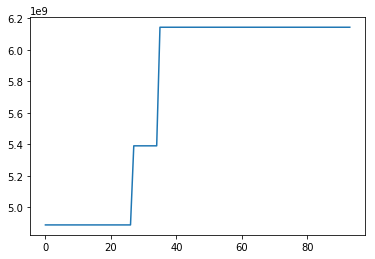

In [14]:
plt.plot(mem_usage)

5626054144